# 18기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [19]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cl
uster import *
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial as sp 

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

SyntaxError: ignored

##1.데이터 확인 및 전처리

In [20]:
df.describe()
#4개의 열을 가진 고객 200명의 데이터

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [21]:
df.info()
#gender는 categorical,나머지는 정수형->범주형인 gender는 One-hot encoding 필요
#결측치 없음 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [22]:
#Gender_One-Hot-Encoding
encoder = OneHotEncoder().fit(df[['Gender']])     # One-Hot-Encoding
encoder.get_feature_names(['Gender'])

array(['Gender_Female', 'Gender_Male'], dtype=object)

In [23]:
endcoded_data = pd.DataFrame(encoder.transform(df[['Gender']]).toarray(), index = df.index,
                             columns = encoder.get_feature_names(['Gender'])) 

data = pd.concat([df, endcoded_data], sort = False, axis = 1).drop(['Gender'], axis = 1)
data     # One-Hot-Encoding 완료한 DataFrame

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0.0,1.0
2,21,15,81,0.0,1.0
3,20,16,6,1.0,0.0
4,23,16,77,1.0,0.0
5,31,17,40,1.0,0.0
...,...,...,...,...,...
196,35,120,79,1.0,0.0
197,45,126,28,1.0,0.0
198,32,126,74,0.0,1.0


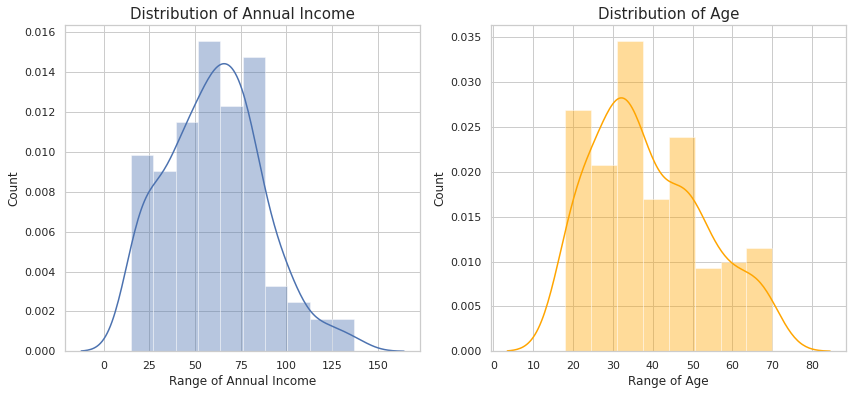

In [24]:
#나이,소득 분포 시각화
plt.rcParams['figure.figsize'] = (14, 6)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(df['Annual Income (k$)'])
plt.title('Distribution of Annual Income', fontsize = 15)
plt.xlabel('Range of Annual Income')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(df['Age'], color = 'orange')
plt.title('Distribution of Age', fontsize = 15)
plt.xlabel('Range of Age')
plt.ylabel('Count')
plt.show()

소득_100이상부터 급격히 떨어진다.
평균소득 60.56

나이_mall에 출입하는 최소나이는 18,최대70까지 입장
평균 38.85세

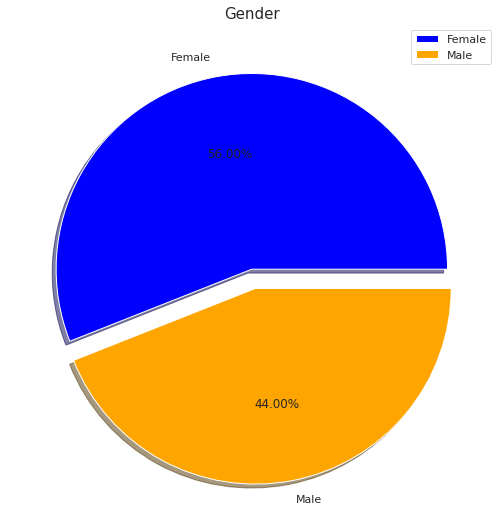

In [25]:
#성별 비율 확인
labels = ['Female', 'Male']
size = df['Gender'].value_counts()
colors = ['blue', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()
#Female이 56%로 주소비자


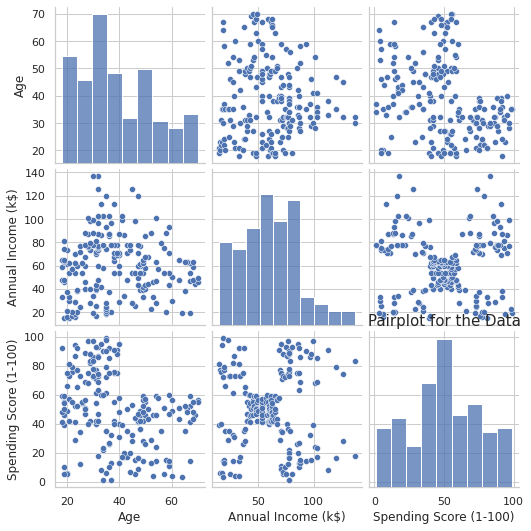

In [26]:
sns.pairplot(df)
plt.title('Pairplot for the Data', fontsize = 15)
plt.show()
##Annual income과 spending score간의 상관관계가 명확해 보인다.

Text(0.5, 1.0, 'Correlation Factors Heat Map')

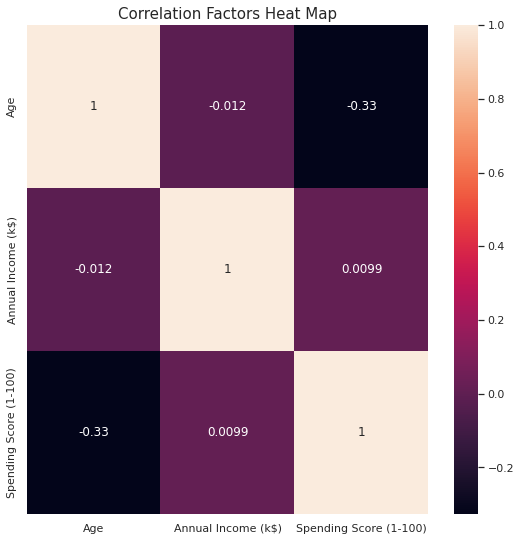

In [27]:
## Correlation coeffecients heatmap
sns.heatmap(df.corr(), annot=True).set_title('Correlation Factors Heat Map', size='15')

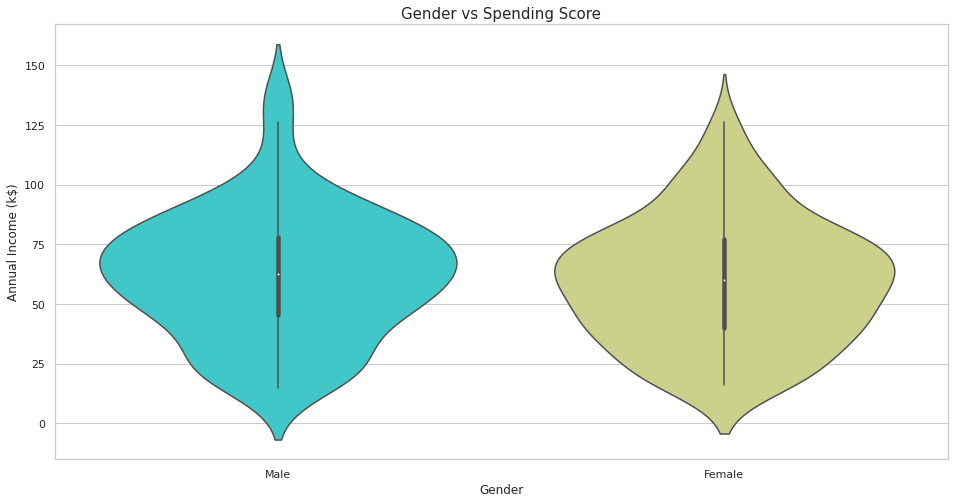

In [28]:
plt.rcParams['figure.figsize'] = (16,8)
sns.violinplot(df['Gender'], data['Annual Income (k$)'], palette = 'rainbow')
plt.title('Gender vs Spending Score', fontsize = 15)
plt.show()
#전체적인 소비자 층 비율은 여성이 높다.비교적 더 많은 남성들이 여성보다 높은 연봉을 받는다.

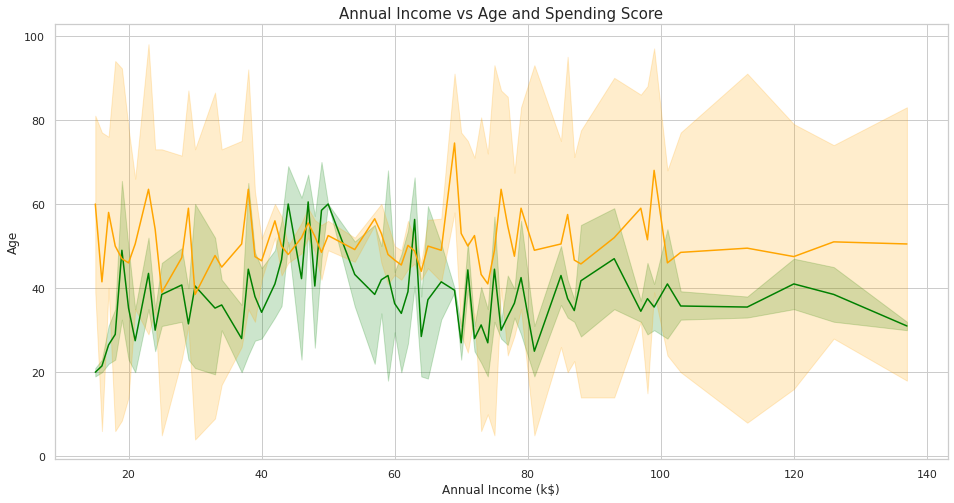

In [29]:
x = df['Annual Income (k$)']
y = df['Age']
z = df['Spending Score (1-100)']

sns.lineplot(x, y, color = 'green')
sns.lineplot(x, z, color = 'orange')
plt.title('Annual Income vs Age and Spending Score', fontsize = 15)
plt.show()

##Clustering 알고리즘 적용
1.K_Means Algorithm with elbow method
대표적인 분리형 군집화 알고리즘

각 개체는 가장 가까운 중심에 할당되며 같은 중심에 할당된 개체들이 모여 하나의 군집을 형성(각 군집은 하나의 중심을 가진다.)

사전에 군집의 수 K가 정해져야 알고리즘을 실행

-elbow method
군집 내 편차제곱합이 최소가 되도록 군집의 중심을 결정해 나가는 방법
WSS의 총합이 급격하게 감소하기 시작((이를 그래프로 나타낼 때,팔꿈치의 모양과 유사)하는 K를 선택

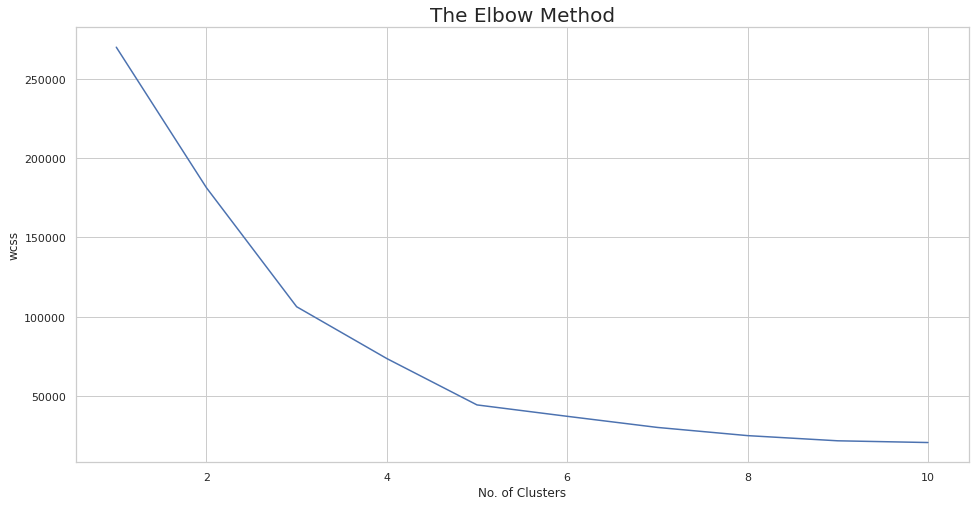

In [38]:
from sklearn.cluster import KMeans

x = data.iloc[:, [1, 2]].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

elbow method 적용 결과 k=3~5가 적절할 것으로 판단됨.

In [41]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

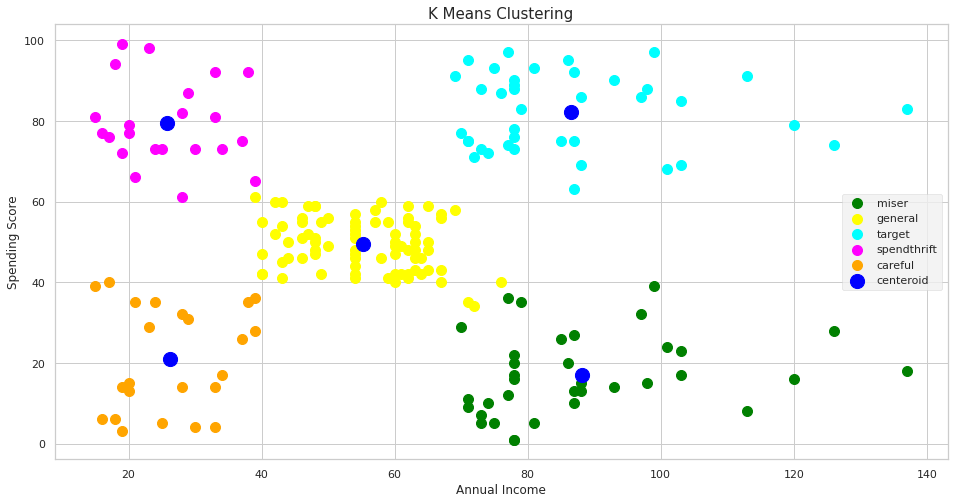

In [42]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 100, c = 'green', label = 'miser')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'yellow', label = 'general')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 100, c = 'cyan', label = 'target')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 100, c = 'magenta', label = 'spendthrift')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 100, c = 'orange', label = 'careful')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 200, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 15)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

In [50]:
x = data.iloc[:, [0, 2]].values
x.shape

(200, 2)

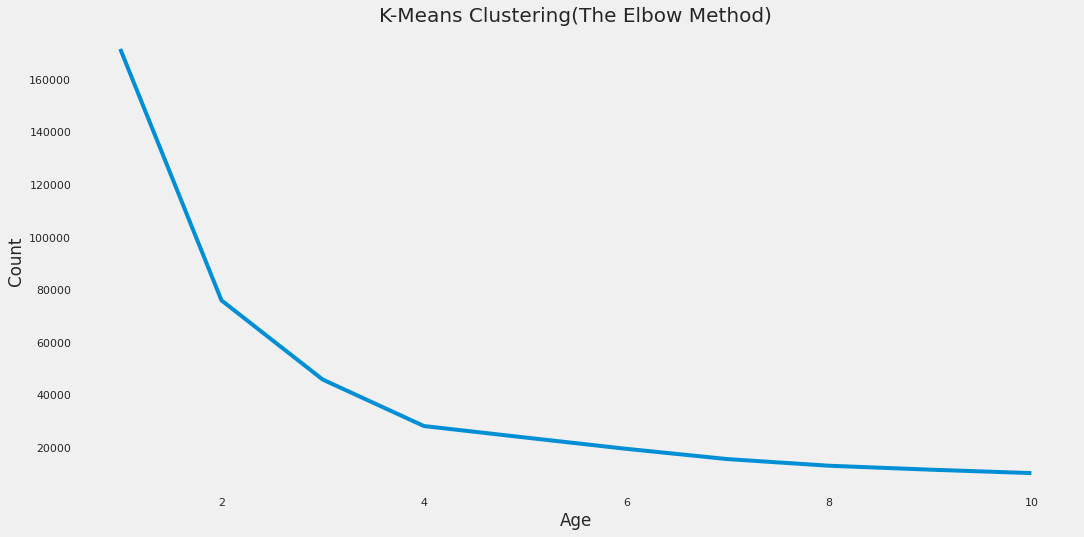

In [51]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (16, 8)
plt.plot(range(1, 11), wcss)
plt.title('K-Means Clustering(The Elbow Method)', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid()
plt.show()

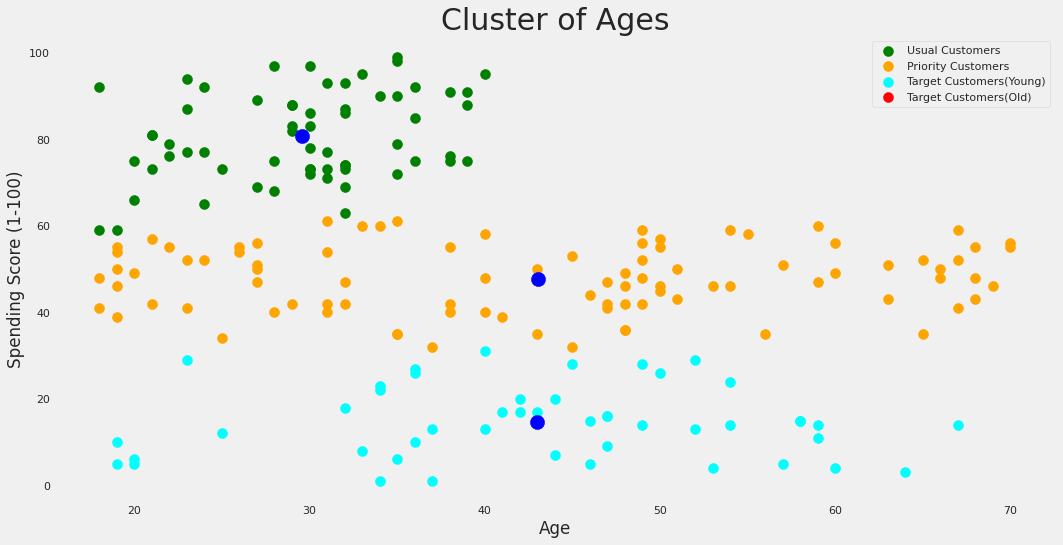

In [53]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
ymeans = kmeans.fit_predict(x)

plt.rcParams['figure.figsize'] = (16, 8)
plt.title('Cluster of Ages', fontsize = 30)

plt.scatter(x[ymeans == 0, 0], x[ymeans == 0, 1], s = 100, c = 'green', label = 'Usual Customers' )
plt.scatter(x[ymeans == 1, 0], x[ymeans == 1, 1], s = 100, c = 'orange', label = 'Priority Customers')
plt.scatter(x[ymeans == 2, 0], x[ymeans == 2, 1], s = 100, c = 'cyan', label = 'Target Customers(Young)')
plt.scatter(x[ymeans == 3, 0], x[ymeans == 3, 1], s = 100, c = 'red', label = 'Target Customers(Old)')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'blue')

plt.style.use('fivethirtyeight')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid()
plt.show()

Spending Score의 상위그룹 60-100에는 50세 이하만이 위치하고 있으며,하위그룹은 반대로 주로 평균 age이상이 자리하고 있는 것으로 보아 주고객층은 20-30대임을 다시 한번 확인할 수 있다.

##2.Hierarchial Clustering

개체들을 가까운 집단부터 차근차근 묶어나가는 방식

순차적/계층적으로 유사한 개체/군집과 통합한다.

군집화 결과 뿐만 아니라 유사한 개체들이 결합되는 덴드로그램(개체들이 결합되는 순서를 나타내는 트리 형태의 구조) 생성

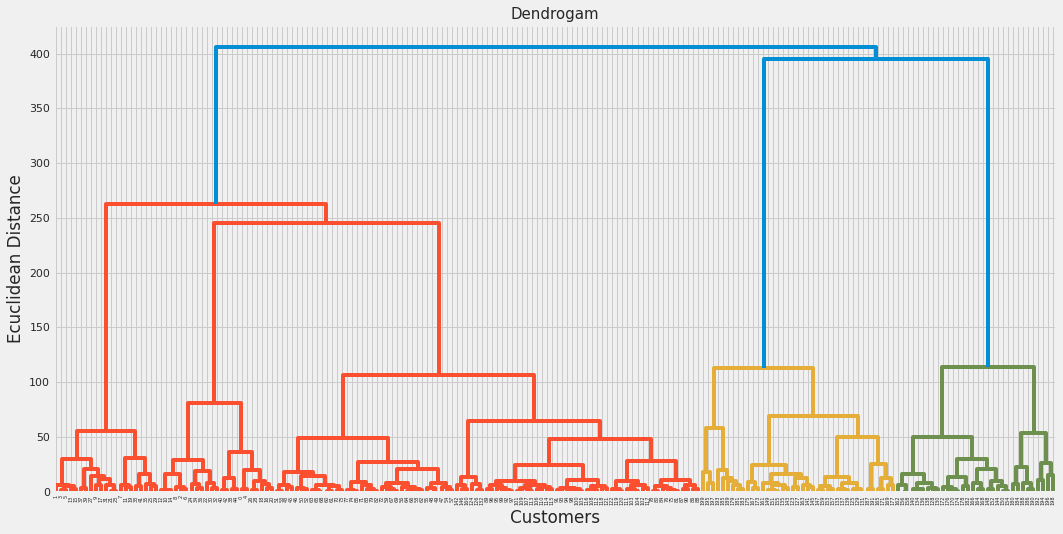

In [43]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
plt.title('Dendrogam', fontsize = 15)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

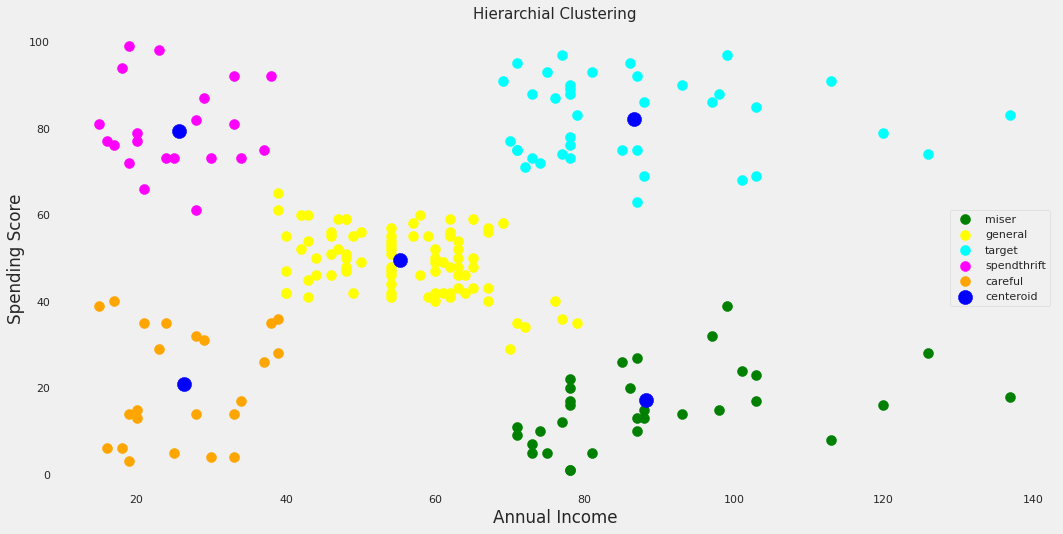

In [44]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(x)

plt.scatter(x[y_hc == 0, 0], x[y_hc == 0, 1], s = 100, c = 'green', label = 'miser')
plt.scatter(x[y_hc == 1, 0], x[y_hc == 1, 1], s = 100, c = 'yellow', label = 'general')
plt.scatter(x[y_hc == 2, 0], x[y_hc == 2, 1], s = 100, c = 'cyan', label = 'target')
plt.scatter(x[y_hc == 3, 0], x[y_hc == 3, 1], s = 100, c = 'magenta', label = 'spendthrift')
plt.scatter(x[y_hc == 4, 0], x[y_hc == 4, 1], s = 100, c = 'orange', label = 'careful')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 200, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 15)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

##3.DBSCAN(밀도)

공간상의 높은 밀도를 가지고 모여있는 관측치들을 하나의 그룹으로 간주하고,낮은 밀도를 가지고 **홀로 있는 관측치는 이상치 또는 잡음**으로 분류하는 밀도 기반 군집화 알고리즘.(이상치에 의해 클러스터링 성능이 하락하는 현상 완화 가능)

-클러스터의 개수 미리 지정할 필요x

매개변수

-1)eps:한 데이터가 주변으로부터 얼마만큼 떨어진 거리를 같은 군집이라고 할 것인가?(주변 거리)

-2)min_samples:적어도 한 군집에 몇 개의 데이터가 있어야 군집이라고 할 것인가?


In [54]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [58]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []
X_numerics = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

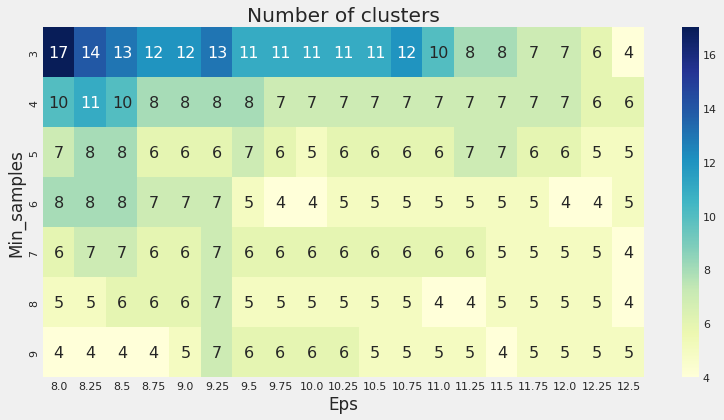

In [59]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()


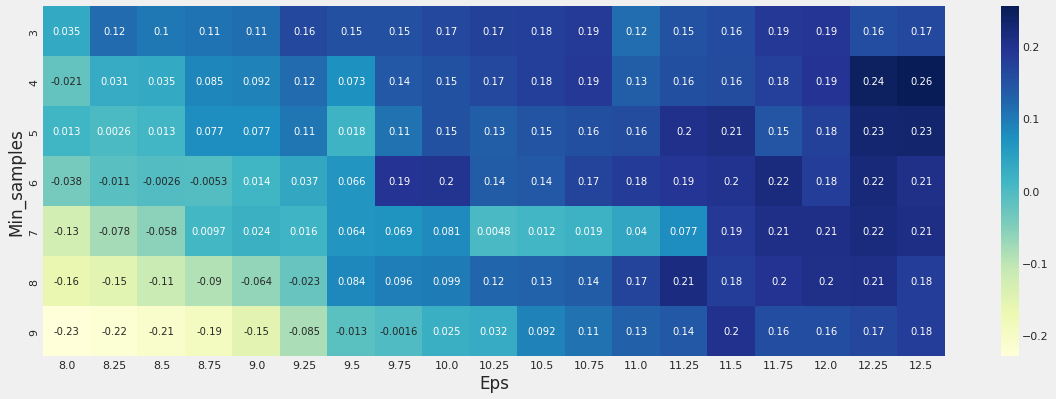

In [60]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum인 0.26에서
eps=12.5

too small ➔ 많은 관측치가 잡음 자료로 분류

too big ➔ 군집의 개수가 너무 작아짐

min_samples는 4로 채택

->**2차원 데이터의 경우 통상적으로 4를 사용**

In [61]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [62]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes
#결과 5개의 cluster를 만들고 밀도에서 벗어난 이상치들을 모아 cluster(-1로 모았다.))

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


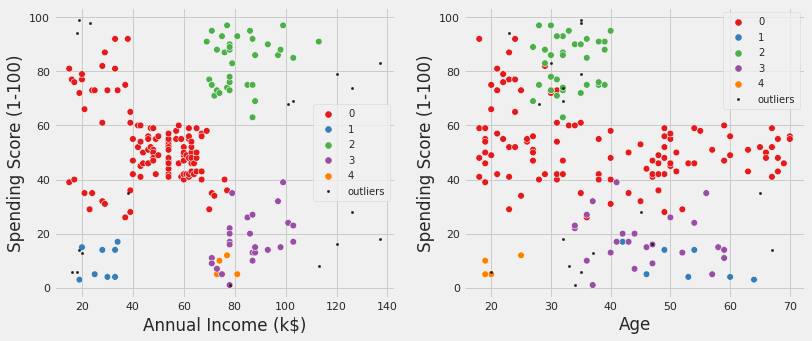

In [63]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()